### Decentralized Blackboard Collaboration

#### Introduction: Enabling Emergent Intelligence
This notebook explores the Decentralized Blackboard Collaboration pattern, a highly flexible and powerful architecture for multi-agent systems. Unlike rigid pipelines or hierarchies, a blackboard system consists of a shared data space (the blackboard) and a collection of independent, specialist agents who watch it. Agents activate themselves opportunistically when the state of the blackboard matches their expertise, contributing their knowledge and incrementally building towards a solution.

<p align="center">
  <img src="../../figures/decentralized_blackboard.png" width="1200">
</p>

#### The Core Concept: Decoupled, Event-Driven Collaboration
The blackboard holds the current state of the problem. Specialist agents don't communicate directly with each other. They only read from and write to the blackboard. A central controller (in our case, a router in LangGraph) observes changes to the blackboard and invites relevant agents to contribute. This creates a dynamic, emergent workflow where the solution is built piece by piece by the most relevant expert at each stage.

#### Role in a Large-Scale System: Facilitating Adaptive Collaboration in Dynamic Environments
This architecture is ideal for complex problems where the exact solution path cannot be predefined. It shines in sense-making and analysis tasks:

- Intelligence Analysis: Multiple agents (a geo-analyst, a signals analyst, a human-source analyst) all post findings to a shared report.
- Scientific Discovery: A system where agents propose experiments, run simulations, and analyze results, posting everything to a shared research log.
- Complex Debugging: A code analysis agent, a log parser, and a network traffic analyzer collaborate to find the root cause of a system failure.


We will build a customer support ticket processing system with three specialist agents collaborating on a blackboard. We will demonstrate how this decoupled approach leads to a more accurate and contextually-rich final output compared to a single agent.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Initialize LLM

In [3]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating a Knowledge Base and Retriever Tool

In [4]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.tools import tool

# 1. Create mock knowledge base documents
kb_docs = [
    "Article 1: To reset your Aura Smart Ring, press and hold the small button on the charger while the ring is docked. Hold for 10 seconds until the light flashes white.",
    "Article 2: The QuantumLeap processor supports a maximum of 128GB of DDR5 RAM. Using more than this can cause system instability.",
    "Article 3: Our Smart Mug's battery is designed to last for 2 hours on a full charge when actively heating. It can last up to 8 hours in standby. Charging takes approximately 90 minutes.",
    "Article 4: To resolve app connectivity issues with the Aura Ring, ensure your phone's Bluetooth is enabled, the ring is charged, and you are running the latest version of the Aura app. If problems persist, try restarting your phone."
]

# 2. Create an embedding model
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 3. Create a FAISS vector store and retriever
vectorstore = FAISS.from_texts(kb_docs, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

@tool
def search_knowledge_base(query: str) -> str:
    """Searches the company's knowledge base for solutions to customer problems."""
    print(f"--- [Tool Call] Searching KB for: {query} ---")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

print(f"Knowledge Base created with {len(kb_docs)} documents.")

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_97733/1288463703.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Knowledge Base created with 4 documents.


### Define data structures for knowledge passing
Next, we need to define the structured data objects that our agents will post to the blackboard. These are the “sticky notes” of their collaboration.

In [2]:
from pydantic import BaseModel, Field
from typing import List, Literal, Optional

class ProblemAnalysis(BaseModel):
    """Structured analysis of the user's problem, posted by the Analyzer agent."""
    product: str = Field(description="The product the user is having an issue with.")
    problem_summary: str = Field(description="A concise, one-sentence summary of the technical problem.")
    user_sentiment: Literal["Positive", "Negative", "Neutral"] = Field(description="The user's sentiment.")

class Solution(BaseModel):
    """A potential solution posted by the Retriever agent."""
    relevant_articles: List[str] = Field(description="A list of knowledge base articles relevant to the problem.")

class DraftResponse(BaseModel):
    """The final response, posted by the Draftsman agent."""
    response_text: str = Field(description="The complete, user-facing response drafted by the agent.")

These Pydantic models are the formal “language” of collaboration for our blackboard system. When the Analyzer agent runs, it must post a ProblemAnalysis object. This make sure that when the Solution Retriever activates, it can reliably find a problem_summary to work with.

### Building the Blackboard Graph
Now we define the state (our blackboard), the specialist agents (nodes), and the central router that orchestrates their collaboration.

In [5]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class BlackboardState(TypedDict):
    # Initial input
    ticket: str
    # Data added by agents
    analysis: Optional[ProblemAnalysis]
    solution: Optional[Solution]
    draft: Optional[DraftResponse]
    # Performance log
    performance_log: Annotated[List[str], add_messages]

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import time

analyzer_parser = JsonOutputParser(
    pydantic_object=ProblemAnalysis
)
# Agent 1: Problem Analyzer
analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Problem Analyzer. Your job is to read a customer support ticket, identify the product, summarize the problem, and gauge the user's sentiment.\n\n{format_instructions}"),
    ("human", "Please analyze the following ticket:\n\n---\n{ticket}\n---")
]).partial(format_instructions=analyzer_parser.get_format_instructions())
analyzer_chain = analyzer_prompt | llm | analyzer_parser

def analyzer_node(state: BlackboardState):
    print("--- [AGENT: Problem Analyzer] Activating... ---")
    start_time = time.time()
    result = analyzer_chain.invoke({"ticket": state['ticket']})
    execution_time = time.time() - start_time
    log = f"[Analyzer] Completed in {execution_time:.2f}s."
    print(log)
    return {"analysis": result, "performance_log": [log]}

In [7]:
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.prompts import MessagesPlaceholder

# Agent 2: Solution Retriever
retriever_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Solution Retriever. Use the knowledge base search tool to find articles relevant to the user's problem."),
    ("human", "Problem: {problem_summary}. Please find a solution."),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])
retriever_agent = create_tool_calling_agent(llm, [search_knowledge_base], retriever_prompt)
retriever_executor = AgentExecutor(agent=retriever_agent, tools=[search_knowledge_base])

def retriever_node(state: BlackboardState):
    print("--- [AGENT: Solution Retriever] Activating... ---")
    start_time = time.time()
    response = retriever_executor.invoke({"problem_summary": state['analysis']["problem_summary"]})
    solution = Solution(relevant_articles=[response['output']])
    execution_time = time.time() - start_time
    log = f"[Retriever] Completed in {execution_time:.2f}s."
    print(log)
    return {"solution": solution, "performance_log": [log]}

In [13]:
# Agent 3: Draftsman
import json

drafter_parser = JsonOutputParser(
    pydantic_object=DraftResponse
)
draftsman_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a Support Response Draftsman. Your job is to write a helpful, empathetic, and clear response to a user based on the problem analysis and retrieved solutions.\n\n{format_instructions}"),
    ("human", "Original Ticket:\n{ticket}\n\nProblem Analysis:\n{analysis}\n\nRetrieved Solution Articles:\n{articles}\n\nPlease draft a response.")
]).partial(format_instructions=drafter_parser.get_format_instructions())
draftsman_chain = draftsman_prompt | llm | drafter_parser

def draftsman_node(state: BlackboardState):
    print("--- [AGENT: Draftsman] Activating... ---")
    start_time = time.time()
    result = draftsman_chain.invoke({
        "ticket": state['ticket'],
        "analysis": json.dumps(state['analysis']),
        "articles": "\n".join(state['solution'].relevant_articles)
    })
    execution_time = time.time() - start_time
    log = f"[Draftsman] Completed in {execution_time:.2f}s."
    print(log)
    return {"draft": result, "performance_log": [log]}

### Defining the Central Router
The router is the controller of our blackboard system. After each step, it inspects the blackboard (the state) and decides which agent should be activated next. This is the core of the event-driven, opportunistic collaboration.

In [14]:
from langgraph.graph import START, END, StateGraph

def router(state: BlackboardState) -> str:
    print("--- [ROUTER] Inspecting blackboard... ---")
    if state.get('draft'):
        print("--- [ROUTER] Decision: Draft is complete. Finishing workflow. ---")
        return END
    if state.get('solution'):
        print("--- [ROUTER] Decision: Solution found. Activating Draftsman. ---")
        return "draftsman"
    if state.get('analysis'):
        print("--- [ROUTER] Decision: Analysis complete. Activating Solution Retriever. ---")
        return "retriever"
    # This should not be reached in this simple graph, but is good practice
    return "analyzer" # Default to analyzer if no other state is present

In [15]:
workflow = StateGraph(BlackboardState)

# Add the nodes
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("retriever", retriever_node)
workflow.add_node("draftsman", draftsman_node)

# The entry point is always the analyzer
workflow.add_edge(START, "analyzer")

# Define the routing logic
workflow.add_conditional_edges(
    "analyzer",
    router,
    {"retriever": "retriever", "draftsman": "draftsman", END: END}
)
workflow.add_conditional_edges(
    "retriever",
    router,
    {"draftsman": "draftsman", END: END}
)
workflow.add_conditional_edges(
    "draftsman",
    router,
    {END: END}
)

app = workflow.compile()

print("Graph constructed and compiled successfully.")
print("The blackboard system is ready for collaboration.")

Graph constructed and compiled successfully.
The blackboard system is ready for collaboration.


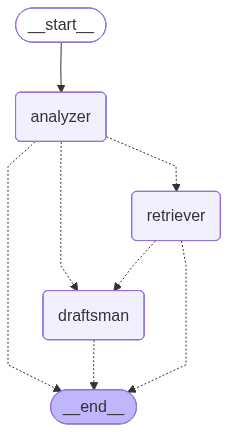

In [16]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

### Running the Blackboard System
Let's process a sample support ticket and observe how the agents collaborate by posting their findings to the blackboard.

In [17]:
import json

ticket = "I'm really frustrated. My new Aura Ring isn't syncing my sleep data to the app. I've tried everything! It seems to track my heart rate just fine during the day, but in the morning, there's no sleep info. What do I do?"
inputs = {"ticket": ticket}

step_counter = 1
final_state = None
for output in app.stream(inputs, stream_mode="values"):
    node_name = list(output.keys())[-1] # Get the last updated node
    print(f"\n{'*' * 100}")
    print(f"**Step {step_counter}: {node_name.replace('_', ' ').title()} Node Execution**")
    print(f"{'*' * 100}")
    step_counter += 1
    final_state = output
    print(f"\n{'-' * 100}")
    print("Blackboard State Change:")
    if node_name == "analyzer":
        print("The Analyzer has activated, read the ticket, and posted a structured `analysis` object to the blackboard. The Router sees this new information and decides to activate the Retriever next.")
    elif node_name == "retriever":
        print("The Retriever saw the problem summary, activated, and used its tool to find relevant articles. It has now posted a `solution` object containing these articles to the blackboard. The Router sees this and activates the Draftsman.")
    elif node_name == "draftsman":
        print("The Draftsman activated because it saw both an `analysis` and a `solution` on the blackboard. It synthesized this information into a final response and posted it as a `draft`. The Router sees the completed draft and terminates the workflow.")
    print(f"{'-' * 100}")


****************************************************************************************************
**Step 1: Performance Log Node Execution**
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Blackboard State Change:
----------------------------------------------------------------------------------------------------
--- [AGENT: Problem Analyzer] Activating... ---
[Analyzer] Completed in 1.23s.
--- [ROUTER] Inspecting blackboard... ---
--- [ROUTER] Decision: Analysis complete. Activating Solution Retriever. ---

****************************************************************************************************
**Step 2: Performance Log Node Execution**
****************************************************************************************************

---------------------------------------------------------------------------------

In [20]:
print("="*60)
print("                 FINAL BLACKBOARD STATE")
print("="*60)
# (a full run has been completed and final_state is populated)
print(json.dumps(final_state, indent=4, default=lambda o: o.model_dump() if hasattr(o, 'dict') else o))

print("\n" + "="*60)
print("                     ACCURACY & QUALITY ANALYSIS")
print("="*60 + "\n")

                 FINAL BLACKBOARD STATE
{
    "ticket": "I'm really frustrated. My new Aura Ring isn't syncing my sleep data to the app. I've tried everything! It seems to track my heart rate just fine during the day, but in the morning, there's no sleep info. What do I do?",
    "analysis": {
        "product": "Aura Ring",
        "problem_summary": "The Aura Ring is not syncing sleep data to the app, despite accurately tracking heart rate during the day.",
        "user_sentiment": "Negative"
    },
    "solution": {
        "relevant_articles": [
            "The issue with the Aura Ring not syncing sleep data, despite accurate heart rate tracking, can be resolved by addressing app connectivity and device settings. Here are the recommended steps:\n\n1. **Ensure Bluetooth is enabled** on your phone and that the Aura Ring is properly connected.\n2. **Verify the ring is charged**\u2014a low battery may prevent data syncing.\n3. **Update the Aura app** to the latest version, as outdate